In [ ]:
import os
import time
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
import os
HOME = os.getcwd()
TARGET = os.path.join(HOME, 'files/')

documents = []
for article in os.listdir(TARGET):
    if article == 'stopwords':
        continue
    path = os.path.join(TARGET, article)
    with open(path, 'r') as file:
        documents.append(file.read())
        
stopwords = []
with open(os.path.join(TARGET, 'stopwords'), 'r') as file:
    for line in file:
        stopwords.append(line.strip())
        
for i, doc in enumerate(documents):
    doc = doc.strip().replace('\n', ' ').lower()
    for word in stopwords:
        doc = doc.replace(' '+word+' ', ' ')
    documents[i] = doc

print(f"Average char-length: \
{np.mean(np.array([len(x) for x in documents]))}")
print(f"Min char-length: {min(len(x) for x in documents)}")
print(f"Max char-length: {max(len(x) for x in documents)}")

Average char-length: 3651.6
Min char-length: 2412
Max char-length: 5873


In [ ]:
# create K-shingles by sliding window approach
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1)-K):
        d1.add(str1[i:i+K])
    print(f"Found {len(d1)} unique shingles, out of {len(str1)} possible.")
    return d1
doc_shingles = [getShingles(s, 5) for s in documents]

Found 2060 unique shingles, out of 3009 possible.
Found 2091 unique shingles, out of 3291 possible.
Found 1918 unique shingles, out of 2412 possible.
Found 2782 unique shingles, out of 3673 possible.
Found 3953 unique shingles, out of 5873 possible.


In [ ]:
def jaccardSim(d1,d2):
    return len(d1.intersection(d2))/len(d1.union(d2))

# itertools.combinations finds all (,n) n-pairs
# then we use a map op on the tuples with jaccardSim
pairs = itertools.combinations(documents, 2)
pair_labels = []
pair_sims = []
for x1, x2 in itertools.combinations(zip(range(len(doc_shingles)),doc_shingles), 2):
    pair_labels.append((x1[0],x2[0]))
    pair_sims.append(jaccardSim(x1[1],x2[1]))
    
print(f"**~~~~~~ True similarity scores ~~~~~~**")
print("Pair\tScore")
print("-"*14)
for pair, score in zip(pair_labels, pair_sims):
    print(f"{pair}\t{score:.3f}")

**~~~~~~ True similarity scores ~~~~~~**
Pair	Score
--------------
(0, 1)	0.093
(0, 2)	0.050
(0, 3)	0.069
(0, 4)	0.336
(1, 2)	0.051
(1, 3)	0.081
(1, 4)	0.294
(2, 3)	0.052
(2, 4)	0.400
(3, 4)	0.083


In [ ]:
# Take union of all sets. Convert to an array and assign
# each element an integer based on position in array
fullset = set.union(*doc_shingles)
shingle_dict = dict(zip(list(fullset),range(len(fullset))))
print(f"There are {len(shingle_dict)} shingles")

There are 7534 shingles


In [ ]:
# Create a hash function
# define as a callable class, so that we only
# intialize random functions once
class HashManager():
    def __init__(self, shingle_dict):
        self.shingle_dict = shingle_dict
        self.N = len(shingle_dict)
        self.params = None
        
    def _initParams(self, n_sig):
        self.params = np.random.randint(self.N, size=[n_sig,2])
    
    def _permuteRow(self, row):
        return (self.params@np.array([1,row]))%self.N
    
    def __call__(self, docs, n_sig, init=True):
        # Initialize if we change signature matrix length
        # or if we request to re-initialize
        if self.params is None or len(self.params) != n_sig or init:
            self._initParams(n_sig)
            
        #initialize signature matrix
        sig = np.full((n_sig, len(docs)), np.inf)
        
        # each doc in docs is assumed to be an iterable object
        for j, doc in enumerate(docs):
            for shingle in doc:
                orig_row = shingle_dict[shingle]
                curr_col = self._permuteRow(orig_row)
                sig[:,j] = np.minimum(sig[:,j],curr_col)
        return sig.astype(int)
    
# run some tests:
try:
    print("Initialization test: ", end="")
    hm = HashManager(shingle_dict)
    print("passed")

    print("Set parameters to right size: ", end="")
    hm._initParams(n_sig=4)
    assert(hm.params.shape == (4,2))
    print("passed")

    print("Permuting a row integer returns array: ", end="")
    curr_col = hm._permuteRow(3)
    assert(curr_col.shape == (4,))
    print("passed")

    print("Compute minhashed signature matrix: ", end="")
    hm(doc_shingles, 4)
    print("passed")
except Exception as e:
    print("failure")
    print(e.args)

Initialization test: passed
Set parameters to right size: passed
Permuting a row integer returns array: passed
Compute minhashed signature matrix: passed


In [ ]:
hm = HashManager(shingle_dict)

In [ ]:
def trueSimScores(doc_shingles):
    pair_labels = []
    pair_sims = []
    idxs = range(len(doc_shingles))
    for x1, x2 in itertools.combinations(zip(idxs,doc_shingles), 2):
        pair_labels.append((x1[0], x2[0]))
        pair_sims.append(jaccardSim(x1[1], x2[1]))
    return dict(zip(pair_labels, pair_sims))
    
def sigSimScores(sig_mat):
#     cols = [sig_mat[:,i] for i in range(sig_mat.shape[1])]
    cols = sig_mat.T
    idxs = range(sig_mat.shape[1])
    
    pair_labels = []
    pair_sims = []
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs, cols),2):
        pair_labels.append((i,j))
        pair_sims.append(np.mean(col1==col2))
    
    return dict(zip(pair_labels, pair_sims))

def printScoreComparison(true_dict, approx_dict):
    print(f"**~~~~~~ Similarity score comparison ~~~~~~**")
    print("Pair\t\tApprox\t\tTrue\t\t%Error")
    for pair, true_value in true_dict.items():
        approx_value = approx_dict[pair]
        err = 100*abs(true_value-approx_value)/true_value
        print(f"{pair}\t\t{approx_value:.3f}\t\t{true_value:.3f}\t\t{err:.2f}")

def candidatePairs(score_dict, threshold):
    return set(pair for pair, scr in score_dict.items() if scr>=threshold)

def accMatrix(true_dict, approx_dict, threshold):
    true_pairs = candidatePairs(true_dict, threshold)
    approx_pairs = candidatePairs(approx_dict, threshold)
    false_negatives = len(true_pairs - approx_pairs)
    false_positives = len(approx_pairs - true_pairs)
    print(f"False negatives: {false_negatives}")
    print(f"Potential false positives: {false_positives}")

sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

print("True pairs:",candidatePairs(true_score_dict, 0.25))
print("Candidate pairs:",candidatePairs(approx_score_dict, 0.25))
accMatrix(true_score_dict, approx_score_dict, 0.4)

# print(f"**~~~~~~ Approximate similarity scores ~~~~~~**")
# print("Pair\t\tApproximate Score\t\tTrue Score")
# print("-"*14)
# for pair, score in sigSimScores(sig_mat):
#     print(f"{pair}\t{score:.3f}")
    
# print(f"**~~~~~~ True similarity scores ~~~~~~**")
# print("Pair\tScore")
# print("-"*14)
# for pair, score in zip(pair_labels, pair_sims):
#     print(f"{pair}\t{score:.3f}")

**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.200		0.093		114.52
(0, 2)		0.300		0.050		501.43
(0, 3)		0.400		0.069		480.77
(0, 4)		0.500		0.336		48.71
(1, 2)		0.200		0.051		289.08
(1, 3)		0.100		0.081		23.51
(1, 4)		0.400		0.294		35.83
(2, 3)		0.200		0.052		286.93
(2, 4)		0.500		0.400		24.94
(3, 4)		0.300		0.083		261.57
True pairs: {(2, 4), (0, 4), (1, 4)}
Candidate pairs: {(2, 4), (0, 4), (3, 4), (0, 3), (1, 4), (0, 2)}
False negatives: 0
Potential false positives: 3


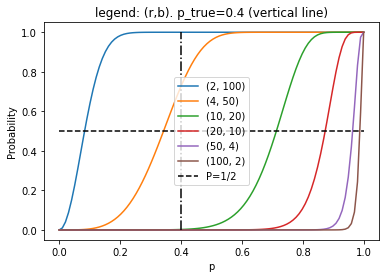

In [ ]:
import matplotlib.pyplot as plt
n = 200
ops = [(2,100),(4,50),(10,20),(20,10),(50,4),(100,2)]
yval = lambda p,r,b: 1-(1-p**r)**b
pts = np.linspace(0,1,100)
yval(pts,.2,.2)
for op in ops:
    plt.plot(pts, yval(pts,op[0],op[1]), label=op)
plt.plot(pts,0*pts+0.5,'k--', label="P=1/2")
plt.plot([0.4,0.4],[0,1], 'k-.')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.4 (vertical line)")
plt.show()

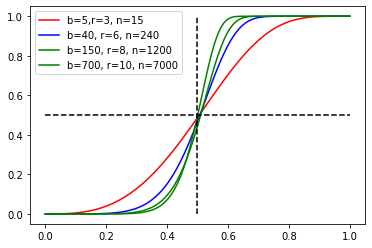

In [ ]:
x = np.linspace(0,1,100)

b,r = 5, 3
y = 1-(1-x**r)**b
plt.plot(x,y,'r-',label=f"b={b},r={r}, n={b*r}")

b,r = 40, 6
y = 1-(1-x**r)**b
plt.plot(x,y,'b-',label=f"b={b}, r={r}, n={b*r}")

b,r = 150, 8
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")

b,r = 700, 10
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")


plt.plot(x,0*x+0.5,'k--')
plt.plot([0.5,0.5],[0,1],'k--')
plt.legend()
plt.show()

In [ ]:
def bandedCandidatePair(col1, col2, b, r):
    """Returns a boolean if the two columns are a candidate pair
    inputs must obey n=len(col1)=len(col2)=b*r"""
    n = len(col1)
    assert(n==b*r)
    assert(n==len(col2))
    truth_array = (col1==col2)
    return any(all(band) for band in np.array_split(truth_array,b))

def bandedCandidatePairs(sig_mat, b, r):
    d = sig_mat.shape[1]
    idxs = range(d)
    cols = [sig_mat[:,i] for i in range(d)]
    pairs = set()
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs,cols),2):
        if bandedCandidatePair(col1,col2,b,r):
            pairs.add((i,j))
    return pairs

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print("True pairs:",candidatePairs(true_score_dict, p))
print("LSH pairs:",bandedCandidatePairs(sig_mat, b, r))
print("Vanilla MinHash pairs:",candidatePairs(approx_score_dict, p))
# accMatrix(true_score_dict, approx_score_dict, 0.4)

# sig_mat = hm(doc_shingles, n)
# true_score_dict = trueSimScores(doc_shingles)
printScoreComparison(true_score_dict, approx_score_dict)

True pairs: {(2, 4), (0, 4)}
LSH pairs: {(0, 4), (3, 4), (1, 4)}
Vanilla MinHash pairs: {(2, 4), (0, 4), (1, 4)}
**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.192		0.093		105.58
(0, 2)		0.192		0.050		284.25
(0, 3)		0.208		0.069		202.48
(0, 4)		0.492		0.336		46.23
(1, 2)		0.108		0.051		110.75
(1, 3)		0.175		0.081		116.14
(1, 4)		0.375		0.294		27.34
(2, 3)		0.125		0.052		141.83
(2, 4)		0.442		0.400		10.36
(3, 4)		0.250		0.083		201.31


In [ ]:
def fastCandidatePairs(sig_mat, b, r):
    n, d = sig_mat.shape
    assert(n==b*r)
    hashbuckets = collections.defaultdict(set)
    bands = np.array_split(sig_mat, b, axis=0)
    for i,band in enumerate(bands):
        for j in range(d):
            # The last value must be made a string, to prevent accidental
            # key collisions of r+1 integers when we really only want
            # keys of r integers plus a band index
            band_id = tuple(list(band[:,j])+[str(i)])
            hashbuckets[band_id].add(j)
    candidate_pairs = set()
    for bucket in hashbuckets.values():
        if len(bucket) > 1:
            for pair in itertools.combinations(bucket, 2):
                candidate_pairs.add(pair)
    return candidate_pairs


# to make sure it works, 
# compare with the brute force method on a few trials

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print('True pairs:\t', candidatePairs(true_score_dict, p))
print("True LSH pairs:\t", bandedCandidatePairs(sig_mat, b, r))
print("Fast LSH pairs:\t", fastCandidatePairs(sig_mat, b, r))
print("MinHash pairs:\t", candidatePairs(approx_score_dict, p))

True pairs:	 {(2, 4), (0, 4)}
True LSH pairs:	 {(0, 4), (1, 4)}
Fast LSH pairs:	 {(0, 4), (1, 4)}
MinHash pairs:	 {(2, 4), (0, 4), (1, 4)}


In [ ]:
b, r = 50, 18

n = b*r
print(f"Transition probability: {(1/b)**(1/r):.2f}")

Transition probability: 0.80


In [ ]:
def cossim(u,v):
    norm = np.linalg.norm(u)*np.linalg.norm(v)
    cosine = u@v/norm
    ang = np.arccos(cosine)
    return 1-ang/np.pi

In [ ]:
# get some random data points
N = 1000
D= 50
A = np.random.randn(N,D)
# artificially make some similar to others
A[5] = A[99] +np.random.randn(D)*0.05
A[20] = A[85] +np.random.randn(D)*0.15
A[13] = A[19] +np.random.randn(D)*0.25
A[56] = A[71] +np.random.randn(D)*0.5
A[45] = A[49] +np.random.randn(D)*0.66

In [ ]:
true_pairs_dict = {}

thresh = 0.8

start = time.time()
for (i,u),(j,v) in itertools.combinations([(i,x) for i,x in enumerate(A)],2):
    val = cossim(u,v)
    if val > thresh:
        true_pairs_dict[(i,j)] = val
t_brute = time.time()-start

# save just the keys without the values. Easier to compare later to LSH
true_pairs = set(true_pairs_dict.keys())

print(f"Brute force calculation time: {t_brute:.3f}")
print(f"Discovered pairs:")
for k, v in true_pairs_dict.items():
    print(f"Pair: {k},\tSimilarity: {v:.2f}.")

Brute force calculation time: 9.362
Discovered pairs:
Pair: (5, 99),	Similarity: 0.98.
Pair: (13, 19),	Similarity: 0.91.
Pair: (20, 85),	Similarity: 0.95.
Pair: (56, 71),	Similarity: 0.86.


In [ ]:
start = time.time()

# Compute signature matrix
R = A@np.random.randn(D,n)
S = np.where(R>0,1,0)

# Break into bands
S = np.split(S, b, axis=1)

# column vector to convert binary vector to integer e.g. (1,0,1)->5
binary_column = 2**np.arange(r).reshape(-1,1)

# convert each band into a single integer, 
# i.e. convert band matrices to band columns
S = np.hstack([M@binary_column for M in S])

# Every value in the matrix represents a hash bucket assignment
# For every bucket in row i, add index i to that bucket
d = collections.defaultdict(set)
with np.nditer(S,flags=['multi_index']) as it:
    for x in it:
        d[int(x)].add(it.multi_index[0])
        
# For every bucket, find all pairs. These are the LSH pairs.
candidate_pairs = set()
for k,v in d.items():
    if len(v) > 1:
        for pair in itertools.combinations(v,2):
            candidate_pairs.add(tuple(sorted(pair)))

# Finally, perform the actually similarity computation
# to weed out false positive
lsh_pairs = set()
for (i,j) in candidate_pairs:
    if cossim(A[i],A[j]) > thresh:
        lsh_pairs.add((i,j))
        
t_lsh = time.time()-start

print(f"LSH calculation time: {t_lsh:.3f}")

LSH calculation time: 0.218


In [ ]:
print(f"t_brute: {t_brute:.3f}\t t_lsh: {t_lsh:.3f}. Speed-up: {t_brute/t_lsh:.0f}x")
print("True pairs: ", true_pairs)
print("LSH pairs: ", lsh_pairs)
print(f"Candidate pairs: {len(candidate_pairs)}.\n\
False negatives: {len(true_pairs-lsh_pairs)}")

t_brute: 9.362	 t_lsh: 0.218. Speed-up: 43x
True pairs:  {(13, 19), (5, 99), (20, 85), (56, 71)}
LSH pairs:  {(13, 19), (5, 99), (20, 85), (56, 71)}
Candidate pairs: 4959.
False negatives: 0
